In [ ]:
import os
import cv2

dataset_path = "dataset" 
healthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry__healthy")))
unhealthy_count = len(os.listdir(os.path.join(dataset_path, "Strawberry___Leaf_scorch")))

print(f"Healthy Images: {healthy_count}")
print(f"Unhealthy Images: {unhealthy_count}")

# Categories which will be turned to classes
categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

# Make sure there are Images and the right Images are being extracted
for category in categories:
    category_path = os.path.join(dataset_path, category)
    first_image = next(iter(os.listdir(category_path)), None)

    if first_image:
        img_path = os.path.join(category_path, first_image)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, channels = img.shape
            print(f"Image size: {width}x{height}, Channels: {channels}")


Healthy Images: 186
Unhealthy Images: 1110
Image size: 256x256, Channels: 3
Image size: 256x256, Channels: 3


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (width, height) 
print(IMG_SIZE)
BATCH_SIZE = 32

# Image data generator with rescaling
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training", 
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation", 
    shuffle=True,
    classes=['Strawberry__healthy', 'Strawberry___Leaf_scorch']
)


(256, 256)
Found 1038 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models

# CNN model made (Sequential ) does binary classification
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(1, activation='sigmoid') 
])

# Show model summary and details
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights according to their counts (images per class), help unbalnced datasets
# 0 = unhealthy, 1 = healthy
labels = [0] * unhealthy_count + [1] * healthy_count  
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)


Computed Class Weights: {0: 0.5837837837837838, 1: 3.4838709677419355}


In [ ]:
import time 
start_time = time.time()  
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15, 
    class_weight=class_weights_dict
) 
end_time = time.time() 
total_time = end_time - start_time
print(f"\nTotal Training time:{total_time:.2f} seconds. {total_time/60:.2f} minutes")

Epoch 1/15
33/33 [==============================] - 34s 956ms/step - loss: 0.3908 - accuracy: 0.8555 - val_loss: 0.1593 - val_accuracy: 0.9305
Epoch 2/15
33/33 [==============================] - 30s 893ms/step - loss: 0.1742 - accuracy: 0.9239 - val_loss: 0.1575 - val_accuracy: 0.9459
Epoch 3/15
33/33 [==============================] - 30s 886ms/step - loss: 0.0890 - accuracy: 0.9538 - val_loss: 0.0524 - val_accuracy: 0.9768
Epoch 4/15
33/33 [==============================] - 28s 838ms/step - loss: 0.0402 - accuracy: 0.9855 - val_loss: 0.1745 - val_accuracy: 0.9537
Epoch 5/15
33/33 [==============================] - 29s 849ms/step - loss: 0.0371 - accuracy: 0.9865 - val_loss: 0.0599 - val_accuracy: 0.9730
Epoch 6/15
33/33 [==============================] - 29s 857ms/step - loss: 0.0210 - accuracy: 0.9923 - val_loss: 0.0511 - val_accuracy: 0.9768
Epoch 7/15
33/33 [==============================] - 28s 853ms/step - loss: 0.0108 - accuracy: 0.9942 - val_loss: 0.0370 - val_accuracy: 0.9807

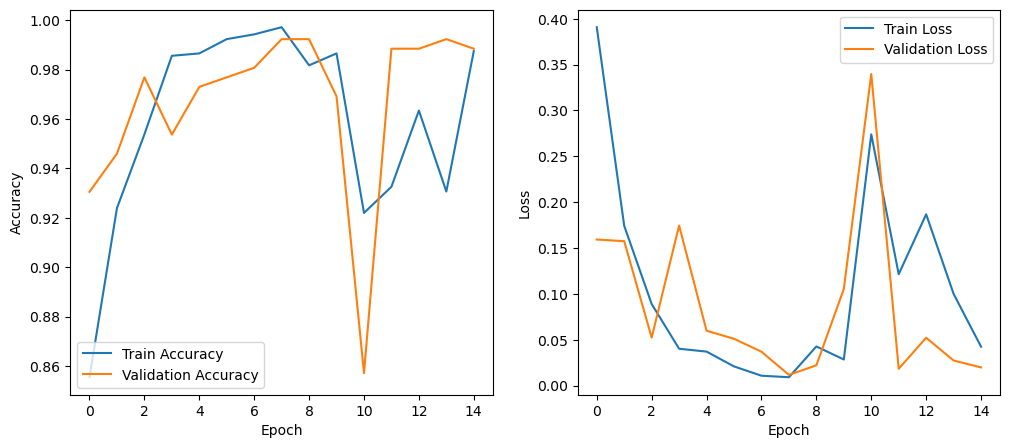

In [42]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
import random
import os

base_dir = "dataset"

categories = ["Strawberry__healthy", "Strawberry___Leaf_scorch"]

def get_random_image():
    """Selects a random image from one of the four datasets and returns its full path."""
     
    category = random.choice(categories)  
    
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    if not images:
        return None 
    random_image = random.choice(images)
    return os.path.join(category_path, random_image)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Function to predict an image and display results
def predict_image(img_path):
    img_name = os.path.basename(img_path)  

    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0) 

    # Predict
    prediction = model.predict(img_array)[0][0] 
    label = "Unhealthy" if prediction > 0.5 else "Healthy"

     # Show the image
    print(f"Image: {img_name}")
    print(f"Prediction Value: {prediction:.4f}")
    print(f"Class: {label}")
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"{img_name}\n{label} ({prediction:.4f})")
    plt.show()


1/1 [==============================] - 0s 103ms/step
Image: 525ea4dd-84e2-4a43-9927-41cd69543db4___RS_HL 4457.JPG
Prediction Value: 0.0729
Class: Healthy


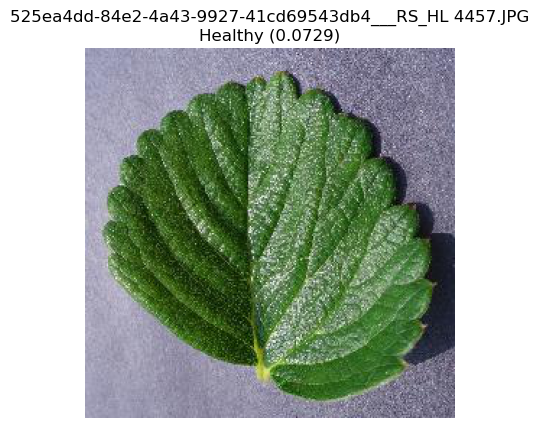

1/1 [==============================] - 0s 37ms/step
Image: 11081be7-ebf9-44b0-aa58-818ccba6f74c___RS_L.Scorch 1573.JPG
Prediction Value: 1.0000
Class: Unhealthy


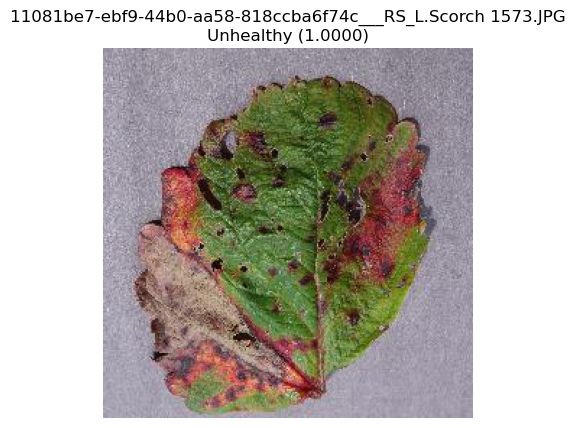

1/1 [==============================] - 0s 30ms/step
Image: 057e51f5-f5c1-40b2-930b-a2346c138969___RS_HL 4596.JPG
Prediction Value: 0.1156
Class: Healthy


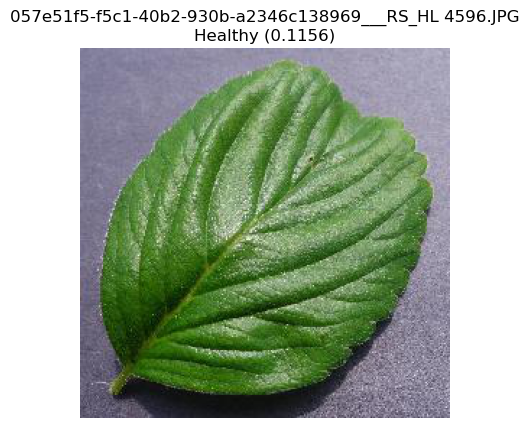

1/1 [==============================] - 0s 28ms/step
Image: 16cb49b2-8d1b-4a66-95fa-9487aa0ba8f1___RS_HL 1665.JPG
Prediction Value: 0.0331
Class: Healthy


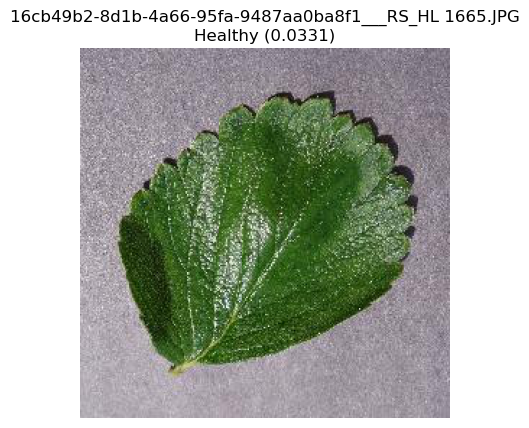

1/1 [==============================] - 0s 31ms/step
Image: 53f62244-534b-49c3-ac2d-c26a1d279b97___RS_HL 2151.JPG
Prediction Value: 0.0029
Class: Healthy


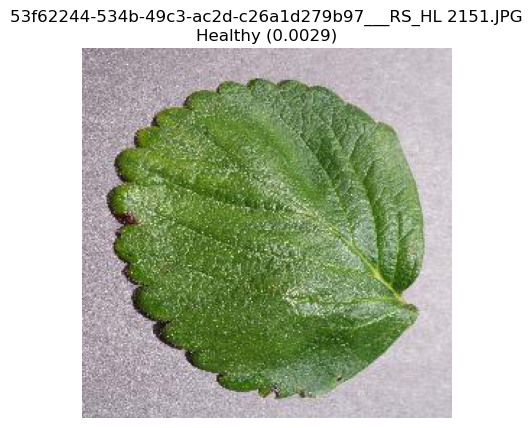

1/1 [==============================] - 0s 37ms/step
Image: 672451d5-6018-4abf-87f8-7b1c0b066136___RS_HL 1902.JPG
Prediction Value: 0.0788
Class: Healthy


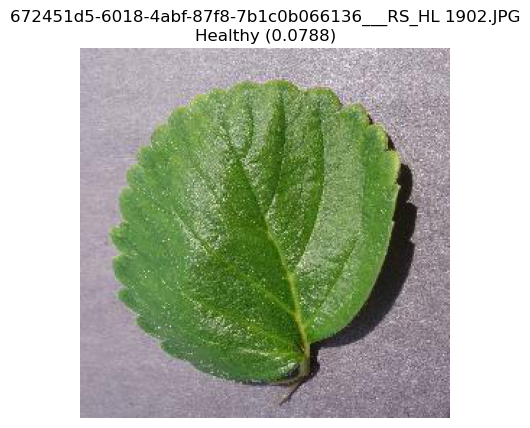

1/1 [==============================] - 0s 29ms/step
Image: 1ec65a98-9f03-4523-90c1-a0d1e238b5a8___RS_HL 4428.JPG
Prediction Value: 0.0412
Class: Healthy


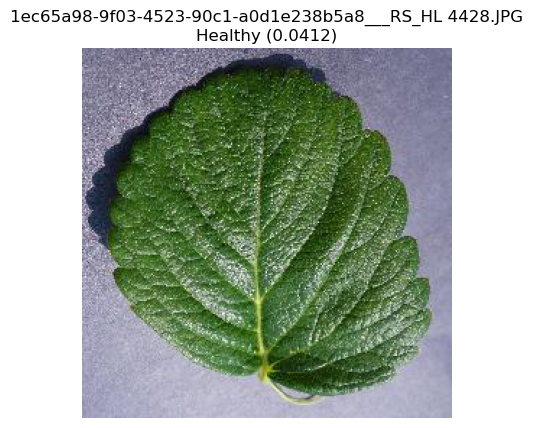

1/1 [==============================] - 0s 28ms/step
Image: 426c35b4-2c26-4532-b10a-a21b0e17f355___RS_HL 2063.JPG
Prediction Value: 0.0346
Class: Healthy


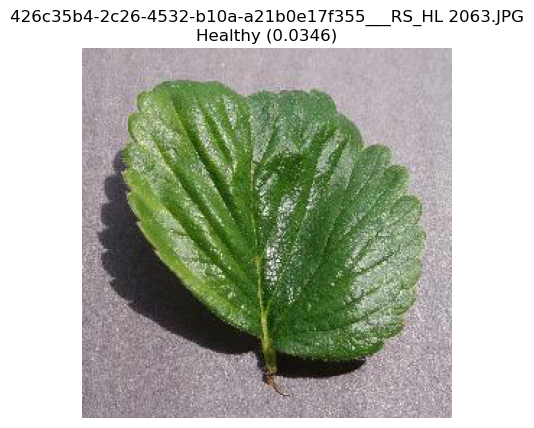

1/1 [==============================] - 0s 31ms/step
Image: 5455791a-eeab-4665-841c-a38e68058b54___RS_HL 2135.JPG
Prediction Value: 0.0225
Class: Healthy


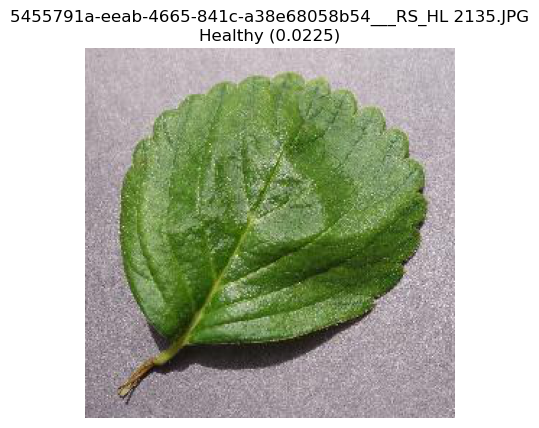

1/1 [==============================] - 0s 29ms/step
Image: 60646de2-333f-40b6-bdf9-f0d1d0e91271___RS_HL 4795.JPG
Prediction Value: 0.0525
Class: Healthy


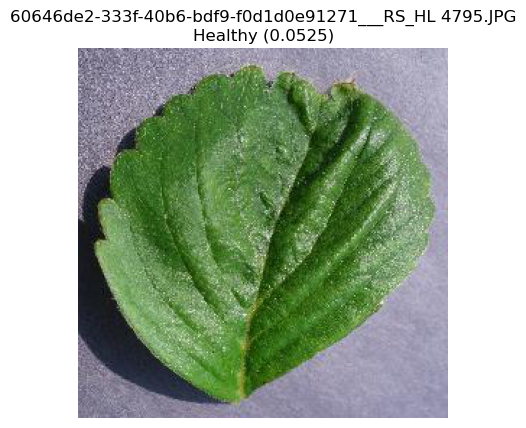

1/1 [==============================] - 0s 38ms/step
Image: 4c5da64b-2f39-4c84-9130-0ff7b8fcda7a___RS_HL 1662.JPG
Prediction Value: 0.0298
Class: Healthy


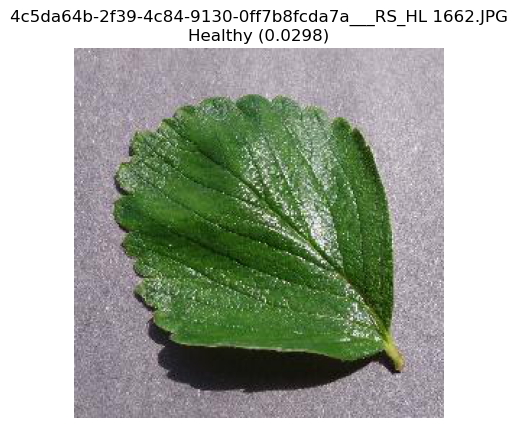

1/1 [==============================] - 0s 26ms/step
Image: bfde826a-4ff5-49e0-b6b8-f3a14f4c7eeb___RS_L.Scorch 9990.JPG
Prediction Value: 1.0000
Class: Unhealthy


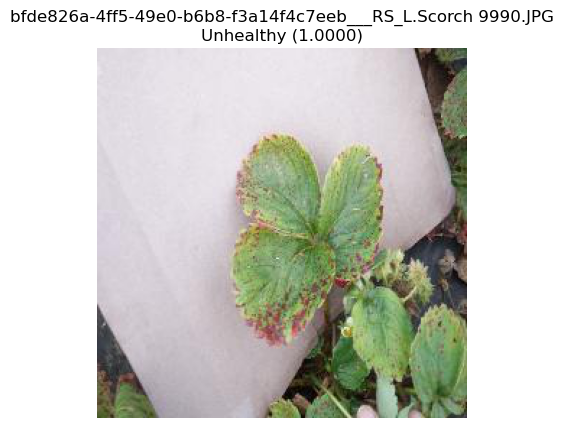

1/1 [==============================] - 0s 24ms/step
Image: 1345a880-f629-49ea-8524-234770fe3cc6___RS_HL 4529.JPG
Prediction Value: 0.0126
Class: Healthy


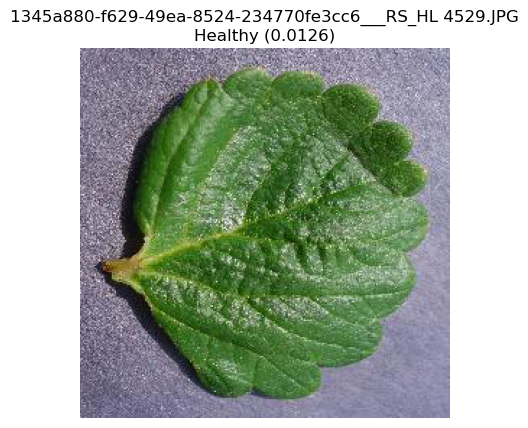

1/1 [==============================] - 0s 31ms/step
Image: 61c8f6ba-9074-44c7-852b-4f34032a6b5e___RS_HL 1721.JPG
Prediction Value: 0.0730
Class: Healthy


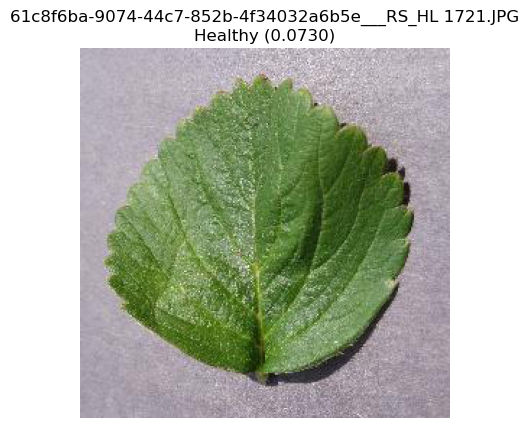

1/1 [==============================] - 0s 43ms/step
Image: 02808b3e-ae88-4259-9b2c-f9096db336e4___RS_HL 1827.JPG
Prediction Value: 0.0117
Class: Healthy


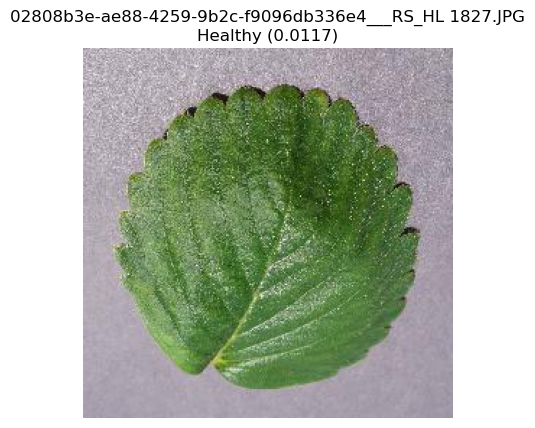

1/1 [==============================] - 0s 37ms/step
Image: 23d4fa2f-a966-44a3-a597-b39a79618378___RS_HL 1744.JPG
Prediction Value: 0.0146
Class: Healthy


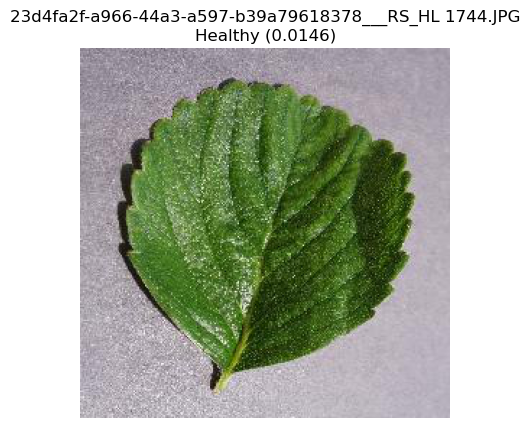

1/1 [==============================] - 0s 52ms/step
Image: 30b0611b-c150-4668-8007-662129beaa6e___RS_HL 1806.JPG
Prediction Value: 0.0048
Class: Healthy


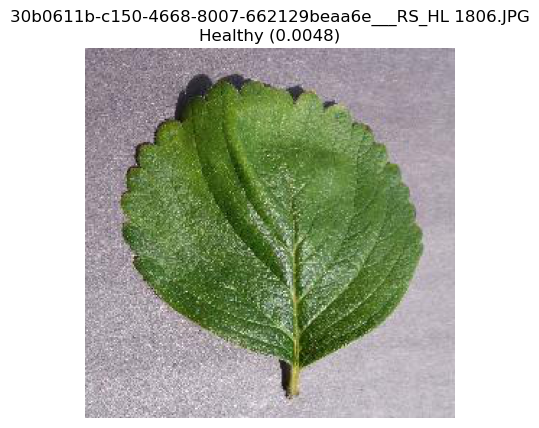

1/1 [==============================] - 0s 33ms/step
Image: ba411e26-5203-4fbe-aa3f-42e7bb1156fc___RS_L.Scorch 0880.JPG
Prediction Value: 1.0000
Class: Unhealthy


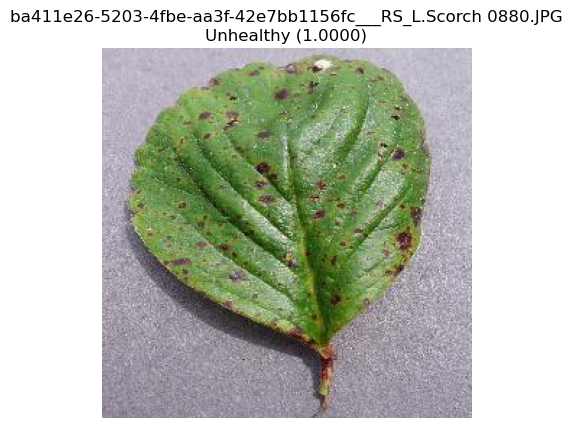

1/1 [==============================] - 0s 31ms/step
Image: c187ece6-ba56-44f8-b5a2-fb10929c68f5___RS_L.Scorch 1170.JPG
Prediction Value: 1.0000
Class: Unhealthy


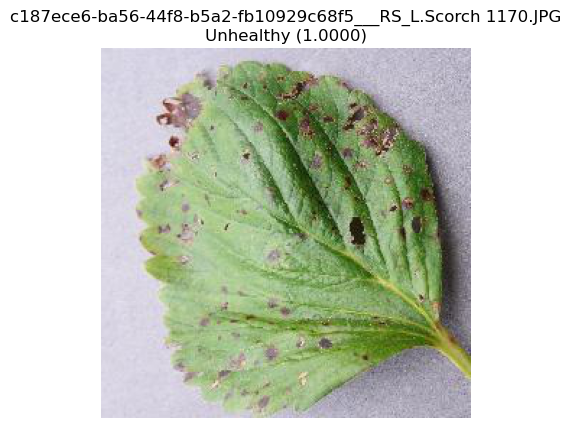

1/1 [==============================] - 0s 30ms/step
Image: 15a5c256-859d-4cff-8b3f-597b8baf3329___RS_HL 4843.JPG
Prediction Value: 0.0087
Class: Healthy


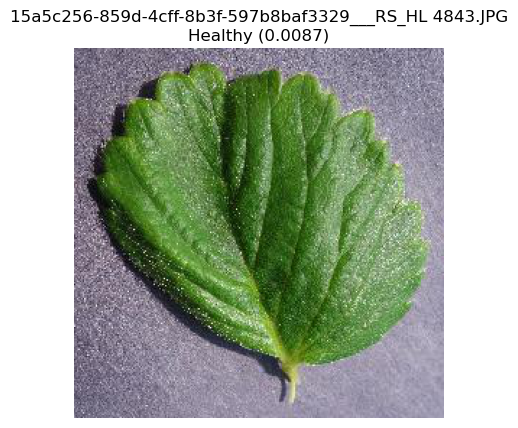

In [ ]:
# Tests a tests amount of immages to visualize results 
tests = 20
for i in range(tests): 
    predict_image("" + get_random_image())